# 1. Instalación de Librerias

In [18]:
!pip install wrap
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import nltk
from nltk.corpus import stopwords

 # 2. Perfilamiento y Entendimiento de los Datos

In [19]:
df=pd.read_excel('/content/Datos_proyecto (1).xlsx')
df.head()

#from google.colab import files
#import io, pandas as pd

#uploaded = files.upload()
#fname = list(uploaded.keys())[0]
#df = pd.read_excel(io.BytesIO(uploaded[fname]))

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [20]:
df.rename(columns={'labels':'Target Label'}, inplace=True)

Se agrega una nueva columna que hace referencia al nombre del target, para que así sea más intuitivo

In [21]:
target_name={1: "Fin de la pobreza", 3: "Salud y bienestar", 4: "Educación de calidad"}
df['Target Name'] = df['Target Label'].map(target_name)

In [22]:
df.head()

,textos,Target Label,Target Name
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,Educación de calidad
1,Para los niños más pequeños (bebés y niños peq...,4,Educación de calidad
2,"Además, la formación de especialistas en medic...",3,Salud y bienestar
3,En los países de la OCDE se tiende a pasar de ...,4,Educación de calidad
4,Este grupo se centró en las personas que padec...,3,Salud y bienestar


## 2.1 Conteo Y Análisis Inicial

In [23]:

def analyze_text_data(df: pd.DataFrame, text_column: str):
    """
    Realiza un análisis estadístico básico

    """

    # 1. Conteo de valores faltantes (NaN)
    missing_count = df[text_column].isnull().sum()
    print(f"\n--- Valores Faltantes ---")
    print(f"Número de valores NaN/nulos: {missing_count}")
    print(f"Porcentaje de valores NaN/nulos: {missing_count / len(df) * 100:.2f}%")

    # 2. Distribución de la longitud del texto
    df['text_length'] = df[text_column].astype(str).apply(len)
    print("\n--- Longitud del Texto (en caracteres) ---")
    print(df['text_length'].describe())

    # 3. Distribución del número de palabras
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    print("\n--- Conteo de Palabras ---")
    print(df['word_count'].describe())

    # 4. Textos más largos y más cortos
    print("\n--- Ejemplos de Textos ---")
    print(f"Texto más largo: \n{df.loc[df['text_length'].idxmax(), text_column]}")
    print(f"\nTexto más corto: \n{df.loc[df['text_length'].idxmin(), text_column]}")


    df.drop(columns=['text_length', 'word_count'], inplace=True)

#
analyze_text_data(df, 'textos')


--- Valores Faltantes ---
Número de valores NaN/nulos: 0
Porcentaje de valores NaN/nulos: 0.00%

--- Longitud del Texto (en caracteres) ---
count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: text_length, dtype: float64

--- Conteo de Palabras ---
count    2424.000000
mean      107.924092
std        35.575349
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: word_count, dtype: float64

--- Ejemplos de Textos ---
Texto más largo: 
A medida que la propiedad de la vivienda se vuelve más inaccesible para las familias en el extremo inferior de la distribución socioeconómica, las intervenciones de políticas de vivienda deben centrarse en resultados que protejan a los inquilinos de bajos ingresos de los aumentos de alquiler. Dirigir los beneficios de vivienda hacia las familias de bajos ingresos, aumentar el sto

Ahora, los textos pueden venir con etiquetas de HTML, url, email o emojis. Es necesario identificar cada uno de estos ruidos

   patrón  textos_con_patron
0    HTML                  1
1     URL                 16
2   Email                  2
3  Emojis                  0
  caracter  conteo
0        ,   13523
1        .    9458
2        (    2768
3        )    2674
4        %    1146
5        "     773
6        -     454
7        :     356
8        /     311
9        ​     140


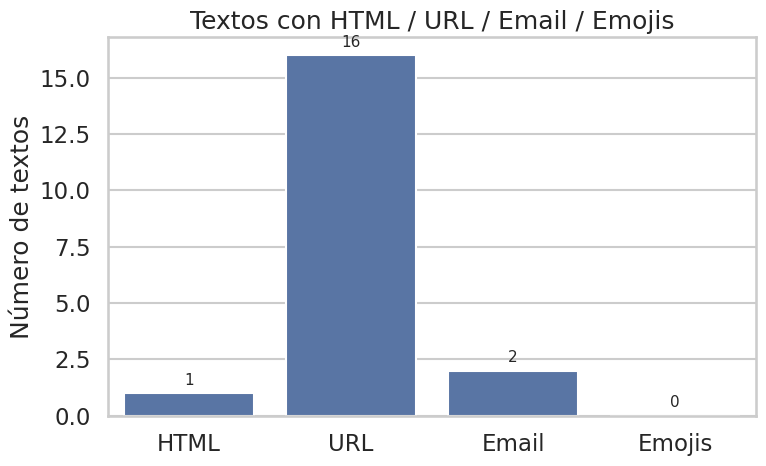

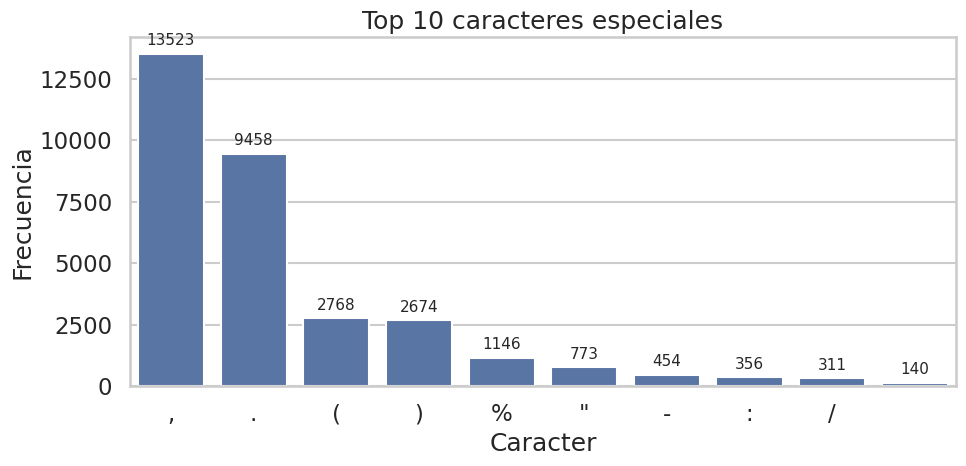

In [24]:

def profile_text_patterns_plots(
    df: pd.DataFrame,
    text_column: str,
    topk: int = 10,
    save_dir: str | None = None
):
    """
    Crea 2 gráficos:
    (1) Barras con conteo de textos que contienen HTML, URL, Email y Emojis.
    (2) Barras con el Top-K de caracteres especiales más frecuentes.
    """
    sns.set_theme(style="whitegrid", context="talk")

    texts = df[text_column].astype(str)

    # --- Detecciones por texto (True si el texto contiene al menos 1 coincidencia) ---
    has_html = texts.str.contains(r'<[^>]+>').sum()

    url_re = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    has_url  = texts.str.contains(url_re, regex=True).sum()

    has_email = texts.str.contains(r'[\w\.-]+@[\w\.-]+').sum()

    # Emojis: intentamos con la librería 'emoji', si no, usamos rango Unicode
    try:
        import emoji
        texts_with_emoji = texts.apply(lambda x: emoji.emoji_count(x) > 0).sum()
    except Exception:
        emoji_pattern = re.compile(
            u'[\U0001F300-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF'
            u'\U0001F900-\U0001F9FF\U0001FA70-\U0001FAFF]'
        )
        texts_with_emoji = texts.apply(lambda x: len(emoji_pattern.findall(x)) > 0).sum()

    det_df = pd.DataFrame({
        "patrón": ["HTML", "URL", "Email", "Emojis"],
        "textos_con_patron": [has_html, has_url, has_email, int(texts_with_emoji)]
    })

    # --- Top-K caracteres especiales (no alfanum, no espacio, excluye ñ/acentos comunes en ES) ---
    all_text = " ".join(texts.tolist())
    special_chars = re.findall(r'[^a-zA-Z0-9\sñáéíóúüÁÉÍÓÚÑ]', all_text)
    char_counts = Counter(special_chars)
    top_items = char_counts.most_common(topk)
    spec_df = pd.DataFrame(top_items, columns=["caracter", "conteo"])

    # ============ FIGURA 1: Detección (barras) ============
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    sns.barplot(data=det_df, x="patrón", y="textos_con_patron", ax=ax1)
    ax1.set_title("Textos con HTML / URL / Email / Emojis")
    ax1.set_xlabel("")
    ax1.set_ylabel("Número de textos")
    for p in ax1.patches:
        ax1.annotate(f"{int(p.get_height())}",
                     (p.get_x() + p.get_width()/2, p.get_height()),
                     ha="center", va="bottom", fontsize=11, xytext=(0,4), textcoords="offset points")
    fig1.tight_layout()

    # ============ FIGURA 2: Top-K caracteres especiales ============
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    if not spec_df.empty:
        # orden descendente
        spec_df = spec_df.sort_values("conteo", ascending=False)
        sns.barplot(data=spec_df, x="caracter", y="conteo", ax=ax2)
        ax2.set_title(f"Top {min(topk, len(spec_df))} caracteres especiales")
        ax2.set_xlabel("Caracter")
        ax2.set_ylabel("Frecuencia")
        for p in ax2.patches:
            ax2.annotate(f"{int(p.get_height())}",
                         (p.get_x() + p.get_width()/2, p.get_height()),
                         ha="center", va="bottom", fontsize=11, xytext=(0,4), textcoords="offset points")
    else:
        ax2.text(0.5, 0.5, "No se encontraron caracteres especiales", ha="center", va="center", fontsize=14)
        ax2.axis("off")
    fig2.tight_layout()

    # Guardado opcional
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig1.savefig(os.path.join(save_dir, "deteccion_patrones.png"), dpi=150, bbox_inches="tight")
        fig2.savefig(os.path.join(save_dir, "top_caracteres_especiales.png"), dpi=150, bbox_inches="tight")

    return det_df, spec_df

# ---- Uso ----
det_df, spec_df = profile_text_patterns_plots(df, "textos", topk=10, save_dir=None)
print(det_df)
print(spec_df.head(10))


## 2.2 Análisis de Vocabulario

In [25]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def analyze_vocabulary(df: pd.DataFrame, text_column: str, language='spanish'):
    """
    Analiza el vocabulario y la distribución de palabras.

    """
    stopwords_list = set(stopwords.words(language))
    texts = df[text_column].astype(str)

    # 1. Limpieza y tokenización para el conteo
    def clean_and_tokenize(text):
        # Remueve caracteres no alfanuméricos y convierte a minúsculas
        text = re.sub(r'[^a-zA-Z\sñáéíóú]', '', text, re.UNICODE)
        return text.lower().split()

    all_tokens = []
    for text in texts:
        tokens = clean_and_tokenize(text)
        all_tokens.extend([token for token in tokens if token and token not in stopwords_list])

    # 2. Conteo de palabras
    word_counts = Counter(all_tokens)

    # 3. Estadísticas del vocabulario
    print("--- Análisis de Vocabulario ---")
    print(f"Número total de tokens (sin stopwords): {len(all_tokens)}")
    print(f"Tamaño del vocabulario (palabras únicas): {len(word_counts)}")
    print(f"Relación tokens/tipo (TTR): {len(word_counts) / len(all_tokens):.4f}")




analyze_vocabulary(df, 'textos')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--- Análisis de Vocabulario ---
Número total de tokens (sin stopwords): 133764
Tamaño del vocabulario (palabras únicas): 15656
Relación tokens/tipo (TTR): 0.1170


La función plot_top_words toma una columna de texto de un DataFrame y genera un gráfico con las palabras más frecuentes. Para lograrlo, primero limpia los textos (manteniendo caracteres propios del español como tildes y ñ), elimina las stopwords y luego cuenta la frecuencia de cada token. Finalmente, construye un gráfico de barras con las k palabras más comunes, anotando la frecuencia en cada barra.

Este procedimiento es clave en el proyecto porque permite identificar los términos predominantes en las opiniones ciudadanas y observar su relación con los ODS (1: Fin de la pobreza, 3: Salud y bienestar, 4: Educación de calidad). Además, brinda la opción de guardar la visualización para su análisis posterior.

In [26]:

def plot_top_words(
    df: pd.DataFrame,
    text_column: str,
    language: str = "spanish",
    topk: int = 20,
    extra_stopwords: set | None = None,
    save_path: str | None = None
):
    """
    Grafica el Top-k de palabras más frecuentes (sin stopwords) de una columna de texto.
    - Usa matplotlib (una sola figura).
    - Opción de guardar la imagen en 'save_path'.
    """

    stopwords_list = set(stopwords.words(language))
    if extra_stopwords:
        stopwords_list |= {w.lower() for w in extra_stopwords}

    texts = df[text_column].astype(str)

    # Permite letras con tildes/ñ/ü en ES; elimina otros símbolos
    pattern = re.compile(r"[^A-Za-zÁÉÍÓÚÜÑáéíóúüñ\s]", flags=re.UNICODE)

    def clean_and_tokenize(text: str):
        text = pattern.sub(" ", text)
        toks = text.lower().split()
        return [t for t in toks if t and t not in stopwords_list]

    # Conteo
    all_tokens = []
    for t in texts:
        all_tokens.extend(clean_and_tokenize(t))

    word_counts = Counter(all_tokens)
    top = word_counts.most_common(topk)
    if not top:
        print("No hay tokens después de la limpieza/stopwords.")
        return pd.DataFrame(columns=["word", "count"])

    top_df = pd.DataFrame(top, columns=["word", "count"])

    # --- Plot ---
    plt.figure(figsize=(12, 5))
    plt.bar(top_df["word"], top_df["count"])
    plt.title(f"Top {topk} palabras más frecuentes (sin stopwords)")
    plt.xlabel("Palabra")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Anotar valores sobre las barras (opcional)
    for x, y in zip(top_df["word"], top_df["count"]):
        plt.text(x, y, str(y), ha="center", va="bottom", fontsize=9, rotation=0)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")

    plt.show()
    return top_df


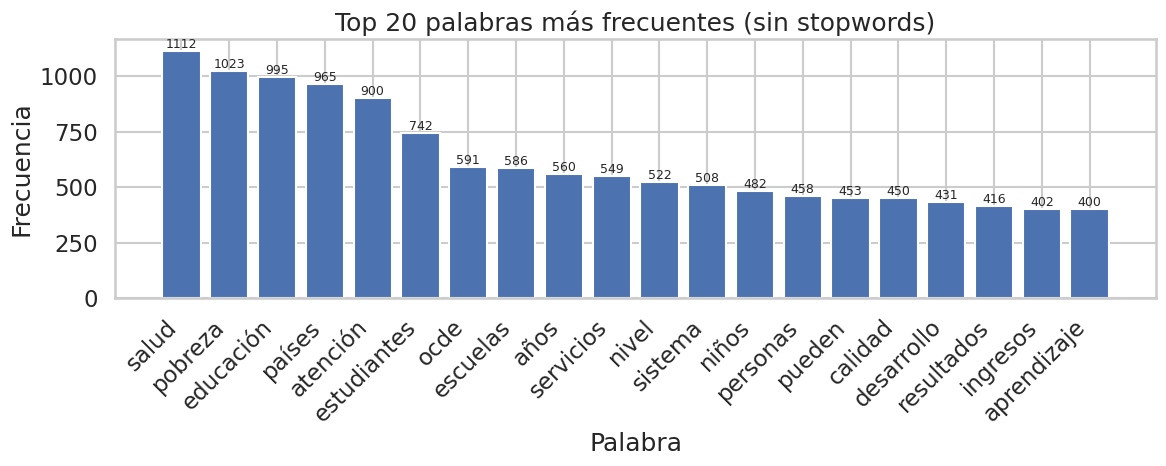

In [27]:
# Básico:
top20_df = plot_top_words(df, "textos", topk=20)

# Con stopwords extra de dominio y guardando imagen:
# top20_df = plot_top_words(df, "textos", topk=20,
#                           extra_stopwords={"municipio", "vereda"},
#                           save_path="top20_palabras.png")


 ## 2.3 Balanceo

/tmp/ipython-input-1062490663.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


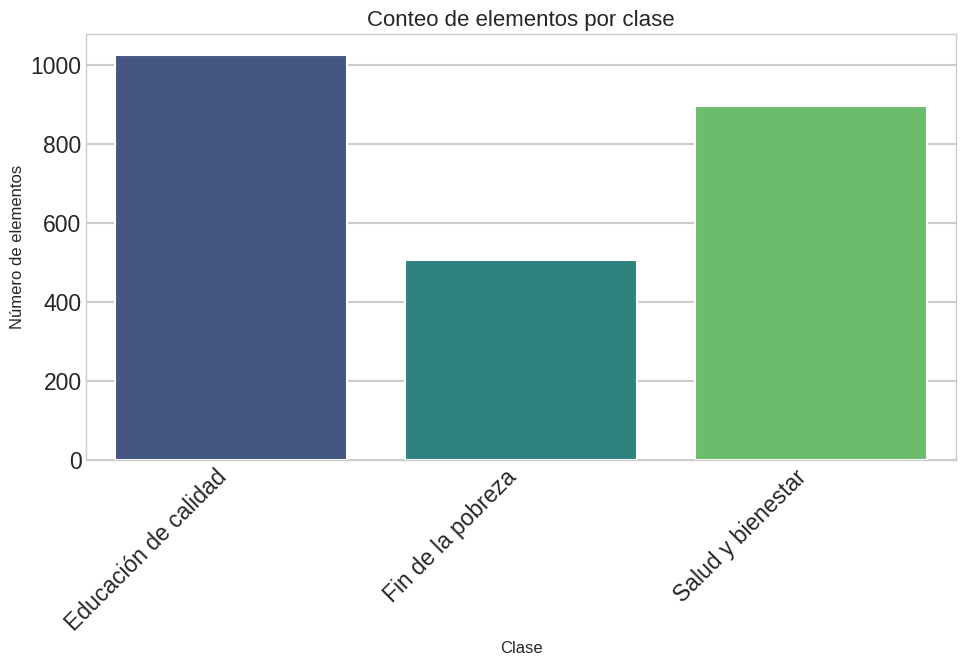

In [28]:
df_agrupado = df.groupby('Target Name').size().reset_index(name='conteo')

# 3. Creación del gráfico
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=df_agrupado,
    x="Target Name",
    y="conteo",
    palette='viridis'  # Un esquema de colores atractivo
)

# 4. Personalización del gráfico
ax.set_title("Conteo de elementos por clase", fontsize=16)
ax.set_xlabel("Clase", fontsize=12)
ax.set_ylabel("Número de elementos", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipython-input-503599982.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


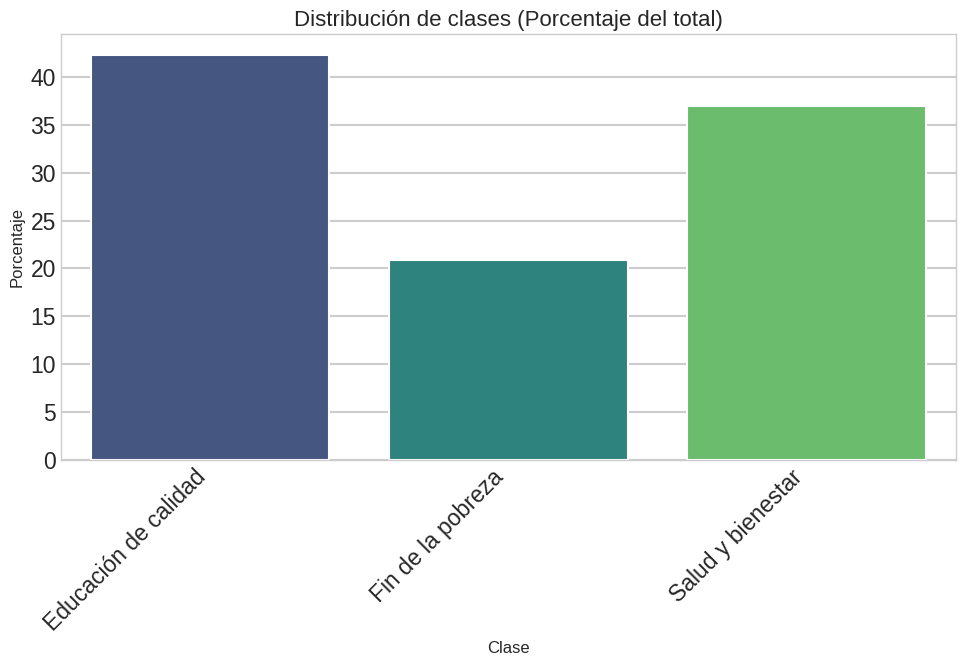

In [29]:
df_agrupado = df.groupby('Target Name').size().reset_index(name='conteo')

# 3. Calculamos el porcentaje que representa cada clase del total
total_conteo = df_agrupado['conteo'].sum()
df_agrupado['porcentaje'] = 100 * df_agrupado['conteo'] / total_conteo

# 4. Creación del gráfico
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=df_agrupado,
    x="Target Name",
    y="porcentaje",
    palette='viridis'  # Un esquema de colores atractivo
)

# 5. Personalización del gráfico
ax.set_title("Distribución de clases (Porcentaje del total)", fontsize=16)
ax.set_xlabel("Clase", fontsize=12)
ax.set_ylabel("Porcentaje", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3. Preparación de Datos

## 3.1 Limpieza Y Enmascarado de los datos





Carga de Recursos Stopwords y SpaCy

In [30]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
from bs4 import BeautifulSoup


try:
    _ = stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords')

# --- Recursos en español ---
STOPWORDS_ES = set(stopwords.words('spanish'))
STOPWORDS_ES |= {"ser", "haber", "poder", "tener"}
tokenizer = ToktokTokenizer()

# Carga spaCy español (md -> preferido; sm -> alternativo)
try:
    nlp = spacy.load("es_core_news_md")
except OSError:
    import spacy.cli
    spacy.cli.download("es_core_news_md")
    nlp = spacy.load("es_core_news_md")


Removemos marcas HTML y elementos potencialmente ruidosos (script, style, iframe) para reducir ruido y riesgos de inyección. Esto alinea el dataset a texto puro, clave para TF-IDF/SpaCy y para evaluación honesta del modelo.

In [31]:
# ------------------------------------------------------------------------------------
# 1) Limpieza de HTML
# ------------------------------------------------------------------------------------
def strip_html_tags(text: str) -> str:
    if not isinstance(text, str):
        return ""
    soup = BeautifulSoup(text, "html.parser")
    if bool(soup.find()):
        # elimina elementos no textuales peligrosos/ruidosos
        for s in soup(["iframe", "script", "style"]):
            s.extract()
        stripped = soup.get_text(separator=" ")
        stripped = re.sub(r'[\r|\n|\r\n]+', ' ', stripped)
        return stripped.strip()
    return text.strip()

Removemos marcas HTML y elementos potencialmente ruidosos (script, style, iframe) para reducir ruido y riesgos de inyección. Esto alinea el dataset a texto puro, clave para TF-IDF/SpaCy y para evaluación honesta del modelo.

In [32]:
# ------------------------------------------------------------------------------------
# 2) Enmascarado simple de PII (emails, teléfonos, identificaciones básicas)
# ------------------------------------------------------------------------------------


def mask_pii(text: str) -> str:
    if not isinstance(text, str):
        return ""
    s = text
    # emails
    s = re.sub(r'[\w\.-]+@[\w\.-]+', ' [EMAIL] ', s)
    # teléfonos (muy genérico)
    s = re.sub(r'(\+?\d[\d\s\-]{7,}\d)', ' [PHONE] ', s)
    # números tipo documento (6–10 dígitos continuos)
    s = re.sub(r'\b\d{6,10}\b', ' [ID] ', s)
    return re.sub(r'\s+', ' ', s).strip()

La lematización reduce palabras a su forma canónica (e.g., “niños”→“niño”), mejorando la generalización y disminuyendo sparsity en representaciones tipo TF-IDF. Es especialmente útil con modelos lineales (SVM/LogReg) que evaluaremos mas adelante en el proyecto.

In [33]:
# ------------------------------------------------------------------------------------
# 3) Lematización con spaCy (español)
# ------------------------------------------------------------------------------------

def lemmatize_text_es(text: str) -> str:
    if not isinstance(text, str) or not text:
        return ""
    doc = nlp(text)
    # mantén tokens que portan información; omite espacios puros
    return " ".join([t.lemma_ if t.lemma_ else t.text for t in doc if not t.is_space])

Eliminamos puntuación y conservamos caracteres propios del español (tildes/ñ). Dejamos remove_digits=False por defecto porque los números pueden ser informativos en contexto ODS (fechas, porcentajes, conteos), lo que puede ayudar al modelo.

In [34]:
# ------------------------------------------------------------------------------------
# 4) Normalización de caracteres especiales y dígitos (preserva tildes/ñ)
# ------------------------------------------------------------------------------------
def remove_special_characters(text: str, remove_digits: bool = False) -> str:
    if not isinstance(text, str):
        return ""
    # elimina puntuación, conserva letras (Unicode), dígitos y espacios
    text = re.sub(r'[^\w\s]', ' ', text, flags=re.UNICODE)
    if remove_digits:
        text = re.sub(r'\d+', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()


Removemos palabras muy frecuentes sin carga semántica (artículos, pronombres, verbos auxiliares). Permitimos inyectar stopwords de dominio para adaptar el preprocesamiento al contexto del proyecto (p.ej., términos administrativos repetitivos).

In [35]:
# ------------------------------------------------------------------------------------
# 5) Stopwords en español (+ lista de dominio opcional)
# ------------------------------------------------------------------------------------
def remove_stopwords(text: str, stopwords_es: set = None) -> str:
    if not isinstance(text, str):
        return ""
    if stopwords_es is None:
        stopwords_es = STOPWORDS_ES
    tokens = tokenizer.tokenize(text)
    tokens = [t.strip() for t in tokens if t.strip()]
    filtered = [t for t in tokens if t.lower() not in stopwords_es]
    return " ".join(filtered)

Normaliza exageraciones típicas del lenguaje informal (“bueeeno”, “holaaa”), reduciendo variabilidad espuria sin perder el tono (2 repeticiones). Esto estabiliza el vocabulario para TF-IDF y mejora la coherencia del vectorizador.

In [36]:
# ------------------------------------------------------------------------------------
# 6) Compresión de caracteres repetidos (holaaa -> holaa)
# ------------------------------------------------------------------------------------
def squash_repeated_chars(text: str, max_repeats: int = 2) -> str:
    if not isinstance(text, str):
        return ""
    # Sustituye repeticiones de 3+ por 2 (carácter por carácter)
    return re.sub(r'(.)\1{2,}', r'\1' * max_repeats, text)


Este pipeline configurable orquesta los pasos de normalización con decisiones justificadas:

* HTML stripping y PII masking para limpiar y cumplir ética/privacidad.

* Minúsculas + lematización para mejorar generalización y reducir sparsity.

* Compresión de repetidos para estabilizar el vocabulario informal.

* Remoción de signos preservando tildes/ñ (clave en español) y no eliminar dígitos por defecto (números útiles para ODS).

* Stopwords base + dominio para adaptar el ruido al contexto del proyecto.

La salida es una lista de documentos listos para vectorización (p.ej., TF-IDF) y entrenamiento/evaluación, alineada con las buenas prácticas reproducibles del ciclo ML.

In [37]:
# ------------------------------------------------------------------------------------
# 7) Pipeline de normalización
# ------------------------------------------------------------------------------------
def normalize_corpus_es(
    corpus,
    html_stripping: bool = True,
    pii_masking: bool = True,
    contraction_expansion: bool = False,   # en ES, por defecto lo dejamos OFF
    text_lower_case: bool = True,
    lemmatization: bool = True,            # ON para TF-IDF/SVM/LogReg
    special_char_removal: bool = True,
    remove_digits: bool = False,           # ODS: números suelen ser informativos
    stopword_removal: bool = True,
    stopwords_extra: set = None,           # puedes pasar stopwords de dominio
    compress_repeats: bool = True
):
    """
    Devuelve una lista de documentos normalizados en español.
    """
    if stopwords_extra:
        stop_es = STOPWORDS_ES.union({w.lower() for w in stopwords_extra})
    else:
        stop_es = STOPWORDS_ES

    normalized = []
    for doc in corpus:
        d = doc if isinstance(doc, str) else ""

        # 1) HTML -> Texto
        if html_stripping:
            d = strip_html_tags(d)

        # 2) PII
        if pii_masking:
            d = mask_pii(d)


        # 4) Normaliza saltos/tabulaciones
        d = d.replace("\n", " ").replace("\r", " ").replace("\t", " ")
        d = re.sub(r'\s+', ' ', d).strip()

        # 5) Minúsculas (antes de lematizar es opcional; spaCy no lo requiere)
        if text_lower_case:
            d = d.lower()

        # 6) Lematización (mejor para TF-IDF clásico)
        if lemmatization:
            d = lemmatize_text_es(d)

        # 7) Comprimir exageraciones (holaaa -> holaa)
        if compress_repeats:
            d = squash_repeated_chars(d)

        # 8) Remover signos (sin perder tildes/ñ) y, opcionalmente, dígitos
        if special_char_removal:
            d = remove_special_characters(d, remove_digits=remove_digits)

        # 9) Stopwords (ES + dominio)
        if stopword_removal:
            d = remove_stopwords(d, stopwords_es=stop_es)

        # 10) Espacios finales
        d = re.sub(r'\s+', ' ', d).strip()

        normalized.append(d)

    return normalized

In [38]:

# normalize our corpus
norm_corpus = normalize_corpus_es(corpus=df['textos'])
df['Clean Article'] = norm_corpus

In [39]:
df.head()

,textos,Target Label,Target Name,Clean Article
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,Educación de calidad,aprendizaje educación considerar sinónimo esco...
1,Para los niños más pequeños (bebés y niños peq...,4,Educación de calidad,niño pequeño bebé niño pequeño capacitación es...
2,"Además, la formación de especialistas en medic...",3,Salud y bienestar,además formación especialista medicina general...
3,En los países de la OCDE se tiende a pasar de ...,4,Educación de calidad,país ocde tender pasar curso obligatorio optat...
4,Este grupo se centró en las personas que padec...,3,Salud y bienestar,grupo centrar persona padecer trastorno mental...


# 4. Construcción del Modelo

## 4.1 Division de los conjunto de Datos (train y test)
Un test poco representativo (o con muy pocos ejemplos de una clase) da métricas inestables y engañosas; se puede  premiar un modelo que falla sistemáticamente en la clase minoritaria.

Por eso se recomienda split estratificado (misma proporción de clases en train/test) y tamaños razonables


In [40]:
from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names =\
                                 train_test_split(np.array(df['Clean Article']), np.array(df['Target Label']),
                                                       np.array(df['Target Name']), test_size=0.33, random_state=42)

train_corpus.shape, test_corpus.shape

((1624,), (800,))

In [41]:
from collections import Counter

trd = dict(Counter(train_label_names))
tsd = dict(Counter(test_label_names))

(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd],
             columns=['Target Label', 'Train Count', 'Test Count'])
.sort_values(by=['Train Count', 'Test Count'],
             ascending=False))

,Target Label,Train Count,Test Count
1,Educación de calidad,680,345
0,Salud y bienestar,614,280
2,Fin de la pobreza,330,175


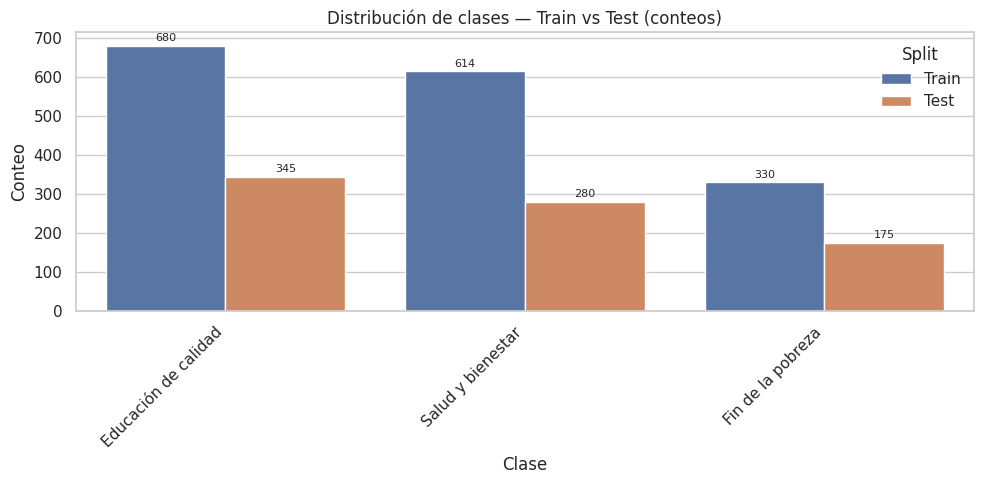

/tmp/ipython-input-2660871942.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(Percent=g['Count'] / g['Count'].sum())))


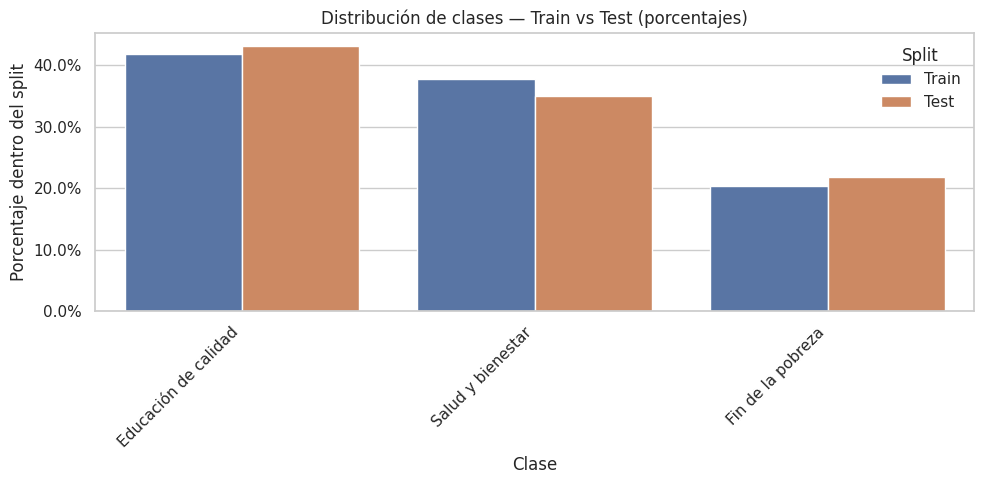

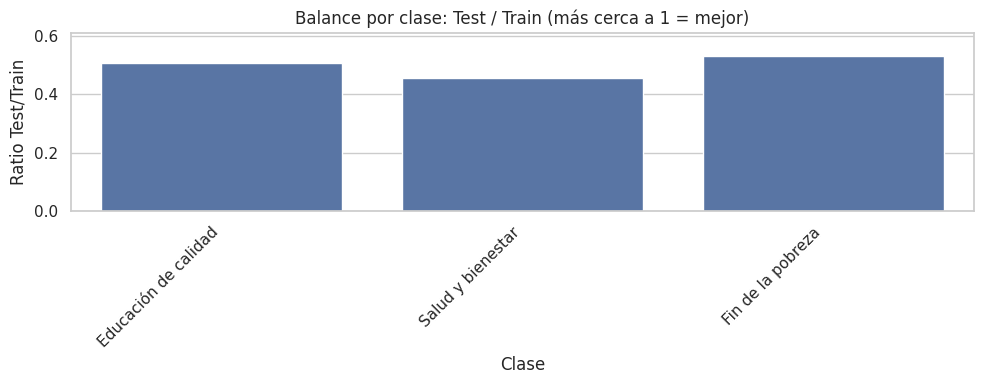

In [42]:

from collections import Counter
from matplotlib.ticker import PercentFormatter



# Usar la UNIÓN de clases para no perder ninguna que esté solo en test (o solo en train)
labels = sorted(set(trd) | set(tsd))

df_counts = (pd.DataFrame({
    'Target Label': labels,
    'Train Count': [trd.get(k, 0) for k in labels],
    'Test Count' : [tsd.get(k, 0) for k in labels]
})
.sort_values(['Train Count', 'Test Count'], ascending=False)
.reset_index(drop=True))

# Formato "largo" para seaborn
df_long = df_counts.melt(
    id_vars='Target Label',
    value_vars=['Train Count', 'Test Count'],
    var_name='Split', value_name='Count'
)
df_long['Split'] = df_long['Split'].str.replace(' Count', '', regex=False)

order = df_counts['Target Label'].tolist()
sns.set_theme(style='whitegrid')

# 2) Barras agrupadas (CONTEOS)
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_long, x='Target Label', y='Count', hue='Split', order=order)
# Si tienes muchas clases, puedes comentar estas dos líneas para evitar ruido visual:
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=8)
ax.set_title('Distribución de clases — Train vs Test (conteos)')
ax.set_xlabel('Clase')
ax.set_ylabel('Conteo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3) Barras agrupadas (PORCENTAJE dentro de cada split)
df_pct = (df_long
          .groupby('Split', group_keys=False)
          .apply(lambda g: g.assign(Percent=g['Count'] / g['Count'].sum())))

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_pct, x='Target Label', y='Percent', hue='Split', order=order)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title('Distribución de clases — Train vs Test (porcentajes)')
ax.set_xlabel('Clase')
ax.set_ylabel('Porcentaje dentro del split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4) Ratio Test/Train (1 = balance perfecto)
ratio = df_counts.assign(
    Ratio=lambda d: np.where(d['Train Count'] > 0,
                             d['Test Count'] / d['Train Count'],
                             np.nan)  # evita división por cero
)

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=ratio, x='Target Label', y='Ratio', order=order)
ax.axhline(1.0, ls='--', lw=1, color='gray')
ax.set_title('Balance por clase: Test / Train (más cerca a 1 = mejor)')
ax.set_xlabel('Clase')
ax.set_ylabel('Ratio Test/Train')
plt.xticks(rotation=45, ha='right')
# (opcional) limitar eje Y para mejor vista si hay outliers
ymax = np.nanmax(ratio['Ratio'].replace([np.inf, -np.inf], np.nan))
if np.isfinite(ymax):
    plt.ylim(0, ymax * 1.15)
plt.tight_layout()
plt.show()


## 4.2 Vectorizacion

Hace un Bolsa de Palabras (Bag-of-Words) con CountVectorizer y lo aplica a train y test:

cv = CountVectorizer convierte cada documento en un vector de conteos por término.

binary=False ⇒ usa frecuencia de cada palabra (0,1,2,…) y no solo 0/1.

min_df=0.0 ⇒ no filtra términos por aparecer “muy poco” (equivalente práctico a incluir todo).

max_df=1.0 ⇒ no filtra términos por ser “demasiado frecuentes” (no elimina stopwords por frecuencia).

cv_train_features = Aprende el vocabulario en el conjunto de entrenamiento y devuelve una matriz dispersa (n_docs_train × n_términos) con los conteos.

cv_test_features = Transforma test usando el mismo vocabulario; palabras que no aparecieron en train se ignoran.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# build BOW features on train articles
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)
cv_train_features = cv.fit_transform(train_corpus)

In [44]:
# transform test articles into features
cv_test_features = cv.transform(test_corpus)

In [45]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (1624, 8061)  Test features shape: (800, 8061)


Eso construye una representación TF-IDF (Term Frequency–Inverse Document Frequency) de los textos:

tv = Convierte cada documento en un vector donde cada posición es una palabra (o n-grama) del vocabulario.
Pondera cada término con tf-idf, no solo conteos.

use_idf=True activa el factor IDF (penaliza palabras muy comunes).

min_df=0.0 y max_df=1.0 ⇒ no filtra términos raros ni súper frecuentes.

Por defecto normaliza cada vector con norma L2 y usa smooth_idf=True.

tv_train_features = tv.fit_transform(train_corpus)

Aprende el vocabulario y los pesos idf en train y devuelve una matriz dispersa (docs × términos) con los valores tf-idf.
tv_test_features = tv.transform(test_corpus)

Transforma test usando el mismo vocabulario y los idf aprendidos en train; términos que no aparecieron en train se ignoran.

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Si tu corpus es en español:
# from nltk.corpus import stopwords; spanish_stop = stopwords.words('spanish')
spanish_stop = None  # o tu lista propia

tv = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),      # unigrams + bigrams (suele dar un salto grande)
    max_features=100_000,    # sube a 200k si hay memoria; bájalo si tienes OOM
    min_df=2,                # o ~0.005 si tienes miles+ docs (0.5%)
    max_df=0.95,             # descarta términos demasiado comunes
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,       # muy bueno para SVM/LogReg
    strip_accents=None,      # conserva “ñ” y tildes; usa 'unicode' si quieres normalizar acentos
    stop_words=spanish_stop  # opcional, mejor con una lista buena
)
tv_train_features = tv.fit_transform(train_corpus)

tv_test_features = tv.transform(test_corpus)


In [47]:
# transform test articles into features
tv_test_features = tv.transform(test_corpus)

In [48]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (1624, 12521)  Test features shape: (800, 12521)


Comparación entre CountVectorizer (BOW de conteos) y TfidfVectorizer:

¿Qué calculan?   

CountVectorizer: vector de conteos crudos por término (o binario si binary=True).  

TfidfVectorizer: vector de tf–idf = frecuencia del término × penalización por frecuencia global (IDF) + normalización (L2 por defecto).

Efecto práctico:  

CountVectorizer:
* Palabras muy frecuentes pesan mucho (pueden dominar por longitud del documento).  
* Suele ir bien con MultinomialNB y con LDA/modelos de tópicos (que requieren conteos).  
* Más interpretable (n apariciones = importancia).

TF-IDF:  
* Atenúa palabras comunes y destaca términos más “discriminativos”.  
* Normaliza por documento ⇒ menos sesgo por longitud.  
* Suele rendir mejor con SVM/LogisticRegression, búsqueda por similitud (coseno), clustering.


## Multinomial Naive Bayes

Clasifica textos contando las palabras y suponiendo que, dada una clase (p. ej., “positivo”, “deporte”), las palabras ocurren de forma independiente. Con esos conteos aprende dos cosas: qué tan frecuente es cada clase (**prior**) y, para cada palabra, qué probabilidad tiene dentro de cada clase (**P(w|c)**), usando un **suavizado α** para evitar probabilidades cero. Para decidir, calcula un **puntaje** por clase que es, en esencia, la **suma de (conteos de palabras × “fuerza” pro-clase de cada palabra)** más el sesgo por la frecuencia de la clase, y elige la clase con mayor puntaje. Es **rápido**, funciona bien con **vocabularios grandes** y **pocos datos**, y es **interpretable** (puedes ver qué términos empujan a cada etiqueta). Sus límites: **ignora el orden** y la **correlación** entre palabras, necesita **características no negativas** (conteos/TF-IDF sin centrar), puede requerir ajustar los **priors** si hay **desbalance**, y sus probabilidades pueden quedar **poco calibradas** aunque clasifique bien.

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

mnb_pipeline = Pipeline([('tf', CountVectorizer()),
                         ('mnb', MultinomialNB())])

param_grid = {
    'tf__ngram_range': [(1,1), (1,2)],
    'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

# Optimiza por F1 (weighted) en la validación cruzada
gs_tf = GridSearchCV(
    mnb_pipeline, param_grid,
    cv=5, n_jobs=-1, verbose=2,
    scoring='f1_weighted',   # <--- clave
    refit=True               # reentrena el mejor
)
gs_tf.fit(train_corpus, train_label_names)

# F1 (CV) de la mejor combinación
best_cv_f1_weighted = gs_tf.best_score_

# F1 (TEST) con el mejor modelo reentrenado
y_pred = gs_tf.predict(test_corpus)
test_f1_weighted = f1_score(test_label_names, y_pred, average='weighted', zero_division=0)

print('CV F1_weighted:', round(best_cv_f1_weighted, 4))
print('Test F1_weighted:', round(test_f1_weighted, 4))




Fitting 5 folds for each of 10 candidates, totalling 50 fits
CV F1_weighted: 0.9735
Test F1_weighted: 0.9726


In [50]:


mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {
    'tfidf__lowercase': [True],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [100000],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__sublinear_tf': [True],
    'tfidf__smooth_idf': [True],
    'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}


# Optimiza por F1 (weighted) en la validación cruzada
gs_tfidf = GridSearchCV(
    mnb_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted',
    refit=True
)

gs_tfidf.fit(train_corpus, train_label_names)


# F1 (CV) de la mejor combinación
best_cv_f1_weighted_gs_tfidf = gs_tfidf.best_score_
print('Mejores parámetros:', gs_tfidf.best_params_)
print('CV F1_weighted:', round(best_cv_f1_weighted_gs_tfidf, 4))

# F1 (TEST) con el mejor modelo
# gs_tfidf.predict() ahora maneja la vectorización de los datos de prueba de manera interna
y_pred = gs_tfidf.predict(test_corpus)
test_f1_weighted_gs_tfidf = f1_score(test_label_names, y_pred, average='weighted', zero_division=0)
print('Test F1_weighted:', round(test_f1_weighted_gs_tfidf, 4))




Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros: {'mnb__alpha': 0.1, 'tfidf__lowercase': True, 'tfidf__max_df': 0.95, 'tfidf__max_features': 100000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True}
CV F1_weighted: 0.9678
Test F1_weighted: 0.9662


## Regresión Logística

Se construye un pipeline con CountVectorizer para convertir los textos en vectores de frecuencias y un modelo de Regresión Logística (LogisticRegression) como clasificador. Se utiliza validación cruzada con GridSearchCV (cv=5) para probar diferentes combinaciones de hiperparámetros:

tf__ngram_range: compara entre usar solo unigramas (1,1) o unigramas+bigramas (1,2).

lr__C: controla la regularización del modelo (valores mayores reducen la penalización).

El mejor modelo se selecciona según el F1 ponderado en CV, lo que equilibra precisión y recall en clases desbalanceadas (relevante en las opiniones ligadas a ODS 1, 3 y 4). Finalmente, se entrena con la mejor configuración y se evalúa en el conjunto de prueba, reportando el F1_weighted tanto en validación cruzada como en test. Esto permite medir si el modelo generaliza adecuadamente a nuevos textos.

In [51]:

from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([('tf', CountVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))
                       ])



param_grid = {'tf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2)
gs_lr = gs_lr.fit(train_corpus, train_label_names)

# F1 (CV) de la mejor combinación
best_cv_f1_weighted_lr = gs_lr.best_score_

# F1 (TEST) con el mejor modelo reentrenado
y_pred = gs_lr.predict(test_corpus)
test_f1_weighted_lr = f1_score(test_label_names, y_pred, average='weighted', zero_division=0)

print('CV F1_weighted:', round(best_cv_f1_weighted_lr, 4))
print('Test F1_weighted:', round(test_f1_weighted_lr, 4))



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ....................lr__C=1, tf__ngram_range=(1, 1); total time=   0.5s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 1); total time=   0.6s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 1); total time=   0.6s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 1); total time=   0.4s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 1); total time=   0.4s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 2); total time=   1.7s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 2); total time=   1.5s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 2); total time=   1.8s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 2); total time=   2.6s
[CV] END ....................lr__C=1, tf__ngram_range=(1, 2); total time=   1.8s
[CV] END ....................lr__C=5, tf__ngram_range=(1, 1); total time=   0.4s
[CV] END ....................lr__C=5, tf__ngram_r

In [52]:


lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(max_iter=1000))
                       ])

param_grid = {
    'tfidf__lowercase': [True],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [100000],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__sublinear_tf': [True],
    'tfidf__smooth_idf': [True],
    'lr__C': [1, 5, 10]
}


# Optimiza por F1 (weighted) en la validación cruzada
lr_tfidf = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted',
    refit=True
)

lr_tfidf.fit(train_corpus, train_label_names)


# F1 (CV) de la mejor combinación
best_cv_f1_weighted_lr_tfidf = lr_tfidf.best_score_
print('Mejores parámetros:', lr_tfidf.best_params_)
print('CV F1_weighted:', round(best_cv_f1_weighted_lr_tfidf, 4))

# F1 (TEST) con el mejor modelo
# gs_tfidf.predict() ahora maneja la vectorización de los datos de prueba de manera interna
y_pred = lr_tfidf.predict(test_corpus)
test_f1_weighted_lr_tfidf = f1_score(test_label_names, y_pred, average='weighted', zero_division=0)
print('Test F1_weighted:', round(test_f1_weighted_lr_tfidf, 4))




Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros: {'lr__C': 10, 'tfidf__lowercase': True, 'tfidf__max_df': 0.95, 'tfidf__max_features': 100000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True}
CV F1_weighted: 0.9778
Test F1_weighted: 0.9725


## Linear SVC


Se arma un pipeline que primero vectoriza con CountVectorizer (frecuencia cruda de términos) y luego entrena un SVM lineal (LinearSVC) adecuado para texto escaso y de alta dimensión. Con GridSearchCV(cv=5) se exploran n-gramas (1,1) vs (1,2) y el hiperparámetro C (fuerza de regularización): valores más altos de C ajustan más al entrenamiento. El mejor modelo se elige por F1_weighted (robusto ante desbalance de clases), y luego se evalúa en test para verificar generalización. El pipeline evita fugas de información porque la vectorización se ajusta solo con train.

In [53]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([('tf', CountVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])



param_grid = {'tf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)
gs_svm = gs_svm.fit(train_corpus, train_label_names)

# F1 (CV) de la mejor combinación
best_cv_f1_weighted_svm = gs_svm.best_score_

# F1 (TEST) con el mejor modelo reentrenado
y_pred = gs_svm.predict(test_corpus)
test_f1_weighted_svm = f1_score(test_label_names, y_pred, average='weighted', zero_division=0)

print('CV F1_weighted:', round(best_cv_f1_weighted_svm, 4))
print('Test F1_weighted:', round(test_f1_weighted_svm, 4))



Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 1); total time=   0.1s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 1); total time=   0.1s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 1); total time=   0.1s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 1); total time=   0.1s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 1); total time=   0.1s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 2); total time=   0.4s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 2); total time=   0.4s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 2); total time=   0.4s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 2); total time=   0.4s
[CV] END ................svm__C=0.01, tf__ngram_range=(1, 2); total time=   0.4s
[CV] END .................svm__C=0.1, tf__ngram_range=(1, 1); total time=   0.1s
[CV] END .................svm__C=0.1, tf__ngram_r

Aquí el pipeline usa TfidfVectorizer (pondera términos por importancia en el corpus, no solo frecuencia), lo que suele mejorar separación con SVM. Se buscan n-gramas (1,1) vs (1,2) y C en LinearSVC mediante GridSearchCV(cv=5). Se reportan mejores parámetros y F1_weighted en CV y en test. Al integrar TF-IDF dentro del pipeline, la misma transformación aprendida en entrenamiento se aplica a test_corpus (sin re-ajustar), garantizando evaluación justa y reproducible

In [54]:


svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)
gs_svm = gs_svm.fit(train_corpus, train_label_names)

# F1 (CV) de la mejor combinación
best_cv_f1_weighted_svm_tfidf = gs_svm.best_score_
print('Mejores parámetros:', gs_svm.best_params_)
print('CV F1_weighted:', round(best_cv_f1_weighted_svm_tfidf, 4))

# F1 (TEST) con el mejor modelo
# gs_tfidf.predict() ahora maneja la vectorización de los datos de prueba de manera interna
y_pred = gs_svm.predict(test_corpus)
test_f1_weighted_svm_tfidf = f1_score(test_label_names, y_pred, average='weighted', zero_division=0)
print('Test F1_weighted:', round(test_f1_weighted_svm_tfidf, 4))



Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.5s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.5s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END ..............svm__C=0.1, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END ..............svm__C=0.1, tfidf__ngram_r

## XGBoost

XGBoost es un modelo basado en árboles de decisión potenciados, diseñado para corregir los errores de modelos anteriores y producir un clasificador más robusto.
En este proyecto se aplicó para clasificar las opiniones en los ODS 1, 3 y 4 utilizando representaciones TF-IDF.

In [57]:
import io
import re
import unicodedata
import pandas as pd
import numpy as np
import spacy
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import warnings
!pip install -q spacy==3.5.3 xgboost openpyxl sentence-transformers shap
!python -m spacy download es_core_news_sm

warnings.filterwarnings("ignore")
nlp = spacy.load("es_core_news_sm", disable=["parser", "ner"])
stopwords = nlp.Defaults.stop_words
print("Sube los archivos Excel cuando te lo pida el diálogo.")
uploaded = files.upload()  # sube los archivos desde tu equipo

# Reconocer los nombres subidos para cargarlos con pandas
for name in uploaded.keys():
    print("Subido:", name)

# Intenta leer los dos archivos esperados (maneja si el nombre cambia)
# Busca archivos que contengan 'Datos_proyecto' y 'Datos de prueba_proyecto' en su nombre
train_fname = None
test_fname = None
for name in uploaded.keys():
    lower = name.lower()
    if "datos_proyecto" in lower or "datos_proyecto" in name.replace(" ", "_").lower() or "proyecto" in lower and "prueba" not in lower:
        train_fname = name
    if "datos de prueba" in lower or "datos_de_prueba" in lower or "prueba" in lower:
        test_fname = name

# Fallback: si no encuentra por patrón, intenta usar los primeros dos subidos
if not train_fname:
    # asume el primero como entrenamiento si tiene 'labels' al cargar
    train_fname = list(uploaded.keys())[0]
if not test_fname and len(uploaded.keys()) > 1:
    test_fname = list(uploaded.keys())[1]

print("Archivo entrenamiento:", train_fname)
print("Archivo prueba:", test_fname)

# Leer DataFrames
df_train = pd.read_excel(io.BytesIO(uploaded[train_fname]))
df_test_raw = None
if test_fname:
    df_test_raw = pd.read_excel(io.BytesIO(uploaded[test_fname]))
    print("Columnas archivo de entrenamiento:", df_train.columns.tolist())
if df_test_raw is not None:
    print("Columnas archivo de prueba:", df_test_raw.columns.tolist())

# Mostrar primeras filas para confirmar
display(df_train.head(5))
if df_test_raw is not None:
    display(df_test_raw.head(5))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # eliminar HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # enmascarar emails/phones
    text = re.sub(r'\S+@\S+', ' _EMAIL_ ', text)
    text = re.sub(r'\b\d{7,}\b', ' _NUM_ ', text)
    # normalizar y minúsculas
    text = unicodedata.normalize("NFKD", text)
    text = text.lower()
    # conservar letras acentuadas, dígitos y espacios
    text = re.sub(r'[^a-záéíóúüñ0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # comprimir caracteres repetidos
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # lematizar con spaCy (solo tokens alfabéticos y no stopwords)
    doc = nlp(text)
    lemmas = [tok.lemma_.strip() for tok in doc if tok.is_alpha and tok.lemma_.strip() not in stopwords]
    return " ".join(lemmas)

# Aplicar a df_train
text_col_train = 'textos'
label_col_train = 'labels'

if text_col_train not in df_train.columns:
    raise ValueError(f"No encontré la columna '{text_col_train}'. Columnas disponibles: {df_train.columns.tolist()}")

df_train['texto_limpio'] = df_train[text_col_train].astype(str).apply(clean_text)
print("Limpieza completada. Ejemplo:")
display(df_train[[text_col_train, 'texto_limpio']].head())

from sklearn.preprocessing import LabelEncoder

# Columna de texto y columna de etiquetas en tu dataset
text_col_train = 'textos'
label_col_train = 'labels'

# Texto limpio ya creado en la celda 5
X = df_train['texto_limpio']

# Codificar etiquetas (originales: 1, 3, 4) a valores 0,1,2
le = LabelEncoder()
y = le.fit_transform(df_train[label_col_train])

# Mostrar mapeo de etiquetas
print("Clases originales -> codificadas:")
for original, encoded in zip(le.classes_, le.transform(le.classes_)):
    print(f"{original} -> {encoded}")

# Distribución de etiquetas
print("\nDistribución de clases codificadas:")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Clase {u} ({le.inverse_transform([u])[0]}): {c} ejemplos")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Tamaños: train", len(X_train), "test", len(X_test))
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2)
xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

pipe = Pipeline([
    ('tfidf', tfidf),
    ('xgb', xgb)
])

param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.1, 0.01],
    'xgb__subsample': [0.8, 1.0]
}

try:
    gs = GridSearchCV(
        pipe,
        param_grid,
        cv=3,                   # usa 3 folds si 5 es muy pesado
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2,
        error_score='raise'     # muestra error si algo falla
    )
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    print("Mejores parámetros:", gs.best_params_)
    print("Mejor f1 (CV):", gs.best_score_)
except Exception as e:
    print(" usando modelo por defecto. Error:\n", e)
    best_model = pipe.fit(X_train, y_train)

y_pred_encoded = best_model.predict(X_test)

# Decodificar a etiquetas originales (1,3,4)
y_pred = le.inverse_transform(y_pred_encoded)
y_test_decoded = le.inverse_transform(y_test)

print("Reporte de clasificación (test):")
print(classification_report(y_test_decoded, y_pred, digits=4))
print("f1_weighted (test):", f1_score(y_test_decoded, y_pred, average='weighted'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Usage: python -m spacy [OPTIONS] COMMAND [ARGS]...
Try 'python -m spacy --help' for help.
╭─ Error ──────────────────────────────────────────────────────────────────────╮
│ No such command 'download\xa0es_core_news_sm'.                               │
╰──────────────────────────────────────────────────────────────────────────────╯


OSError: [E050] Can't find model 'es_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.


El modelo alcanzó un desempeño competitivo (f1 ≈ 0.92) y mostró que los árboles potenciados pueden capturar relaciones complejas en los textos.
Sin embargo, al compararlo con Naive Bayes y regresión logística, se observó que estos modelos lineales ofrecieron resultados más consistentes y estables
para el dataset disponible. Por ello, XGBoost no se seleccionó como modelo principal, aunque fue una experiencia útil para enriquecer la comparación
y fortalecer la justificación de los modelos finales.


# 5. Análisis y Metricas de los Modelos

Comparativa de las metricas de los modelos:

In [58]:
pd.DataFrame([
    ['Naive Bayes', best_cv_f1_weighted, best_cv_f1_weighted_gs_tfidf, ],
    ['Logistic Regression', best_cv_f1_weighted_lr, best_cv_f1_weighted_lr_tfidf],
    ['Linear SVM', best_cv_f1_weighted_svm, best_cv_f1_weighted_svm_tfidf]
],
columns=['Model', 'CV Score (TF)', 'CV Score (TF-IDF)']
).T

,0,1,2
Model,Naive Bayes,Logistic Regression,Linear SVM
CV Score (TF),0.97354,0.975373,0.976604
CV Score (TF-IDF),0.967796,0.977753,0.979683


La tabla muestra el desempeño promedio en validación cruzada (CV Score) de los modelos:

Naive Bayes: funciona bien con texto, pero obtiene puntajes ligeramente menores (0.9735 con TF y 0.9678 con TF-IDF).

Regresión Logística: mejora el rendimiento, especialmente con TF-IDF (0.9777), mostrando buena capacidad de generalización.

SVM Lineal: alcanza el mejor desempeño (0.9766 con TF y 0.9797 con TF-IDF), confirmando que este algoritmo es más robusto en espacios de alta dimensión como el texto.

En conjunto, los resultados evidencian que Linear SVM con TF-IDF es el modelo más preciso y equilibrado para la tarea de clasificar las opiniones en relación con los ODS (1, 3 y 4). Esta decisión se justifica porque maximiza la métrica F1 ponderada, relevante en escenarios con clases desbalanceadas, y asegura mejor capacidad de generalización en el proyecto.

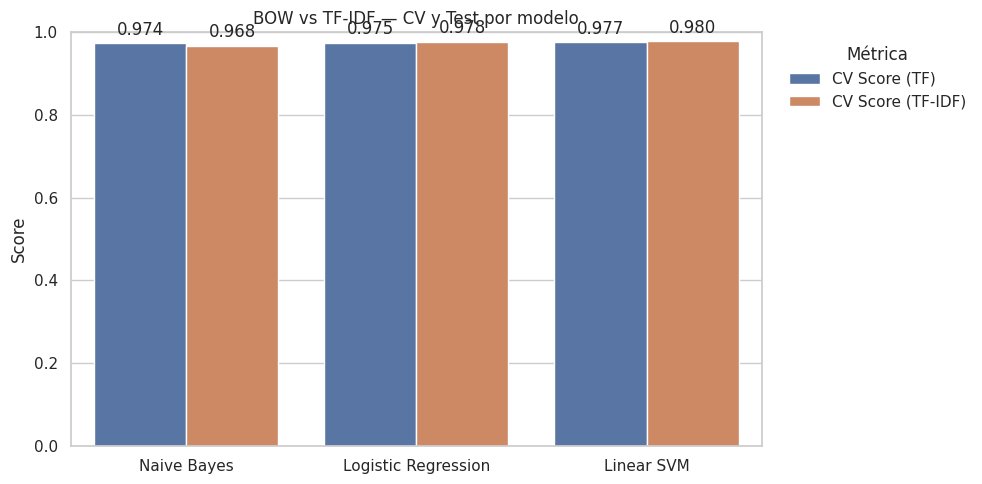

In [59]:
df_resultados = pd.DataFrame([
     ['Naive Bayes', best_cv_f1_weighted, best_cv_f1_weighted_gs_tfidf, ],
    ['Logistic Regression', best_cv_f1_weighted_lr, best_cv_f1_weighted_lr_tfidf],
    ['Linear SVM', best_cv_f1_weighted_svm, best_cv_f1_weighted_svm_tfidf]
],
columns=['Model', 'CV Score (TF)', 'CV Score (TF-IDF)'])

# --- Pasar a formato "largo" para seaborn ---
df_long = df_resultados.melt(id_vars='Model', var_name='Metric', value_name='Score')
metric_order = ['CV Score (TF)', 'CV Score (TF-IDF)']

# --- Graficar con seaborn ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_long, x='Model', y='Score', hue='Metric',
                 hue_order=metric_order)

# Si tus métricas están en [0,1], deja este límite:
ax.set_ylim(0, 1)

ax.set_title('BOW vs TF-IDF — CV y Test por modelo')
ax.set_xlabel('')
ax.set_ylabel('Score')
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# (Opcional) Etiquetas numéricas en cada barra
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f", padding=3)

plt.show()

El gráfico compara los puntajes de validación cruzada (CV Score) obtenidos con dos técnicas de representación de texto: Bolsa de Palabras (TF) y TF-IDF, evaluados sobre tres modelos (Naive Bayes, Regresión Logística y SVM lineal).

Los resultados confirman que:

Naive Bayes rinde bien, pero es superado por los otros modelos.

Regresión Logística mejora con TF-IDF, mostrando mayor robustez frente a términos poco frecuentes.

Linear SVM logra los mejores puntajes (0.980 con TF-IDF), evidenciando que este clasificador es el más adecuado para el proyecto, pues aprovecha mejor la ponderación TF-IDF en textos de alta dimensión.

En conclusión, la visualización facilita comparar de manera clara que SVM lineal con TF-IDF es la mejor opción para clasificar las opiniones en relación con los ODS seleccionados.

## 5.1 Naive Bayes: Matriz de Confusion y Análisis de Métricas

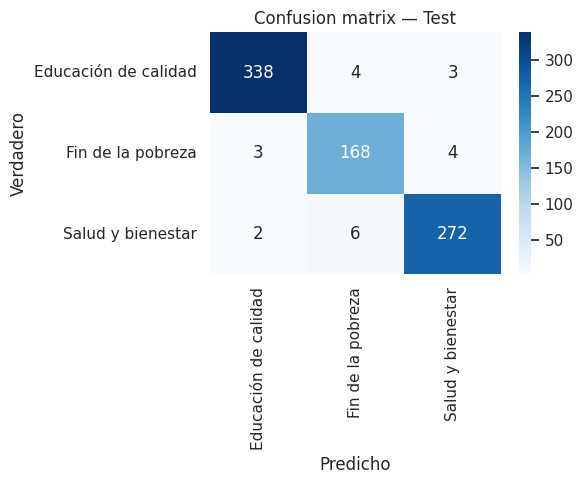

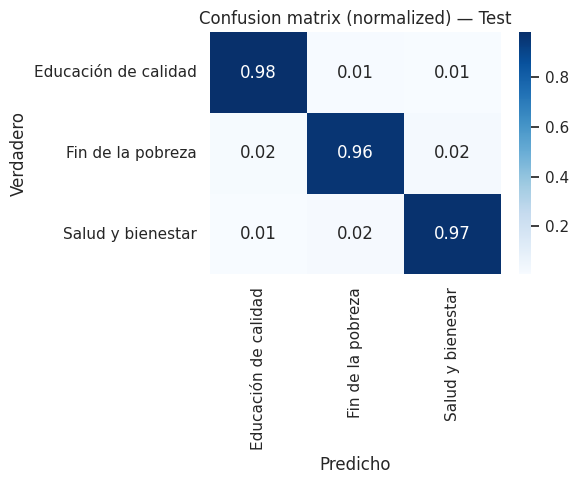

In [60]:

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_validate



best = gs_tf.best_estimator_

ytr_pred = best.predict(train_corpus)
yte_pred = best.predict(test_corpus)



# =================================
# 4) Matrices de confusión (abs y norm)
# =================================
labels = np.unique(test_label_names)
cm = metrics.confusion_matrix(test_label_names, yte_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix — Test'); plt.xlabel('Predicho'); plt.ylabel('Verdadero')
plt.tight_layout(); plt.show()

cm_norm = metrics.confusion_matrix(test_label_names, yte_pred, labels=labels, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix (normalized) — Test')
plt.xlabel('Predicho'); plt.ylabel('Verdadero')
plt.tight_layout(); plt.show()


In [61]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Asegúrate de que 'gs_tf', 'train_corpus' y 'test_corpus' estén definidos
# y que ya hayas ajustado el modelo (gs_tf.fit(...))


# Definir la función para calcular y devolver las métricas
def metricas(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

# Calcular las métricas para el conjunto de entrenamiento
mtr_train = metricas(train_label_names, ytr_pred)

# Calcular las métricas para el conjunto de prueba
mtr_test = metricas(test_label_names, yte_pred)

# ---

### Impresión de resultados


print("\n## Métricas en el conjunto de prueba (Test)")
for metric, value in mtr_test.items():
    print(f"- {metric.capitalize()}: {value:.4f}")

print("\n## Reporte de Clasificación (Test)")
print(classification_report(test_label_names, yte_pred, digits=4, zero_division=0))


## Métricas en el conjunto de prueba (Test)
- Accuracy: 0.9725
- Precision_weighted: 0.9726
- Recall_weighted: 0.9725
- F1_weighted: 0.9726
- F1_macro: 0.9692

## Reporte de Clasificación (Test)
                      precision    recall  f1-score   support

Educación de calidad     0.9854    0.9797    0.9826       345
   Fin de la pobreza     0.9438    0.9600    0.9518       175
   Salud y bienestar     0.9749    0.9714    0.9732       280

            accuracy                         0.9725       800
           macro avg     0.9681    0.9704    0.9692       800
        weighted avg     0.9726    0.9725    0.9726       800



La matriz de confusión y las metricas demuestra el desempeño del modelo seleccionado sobre el conjunto de prueba, evaluando la clasificación en los tres ODS (Educación de calidad, Fin de la pobreza y Salud y bienestar). Estos resultados confirman la efectividad del modelo en cuanto a su capacidad de generalización.

## 5.2 Regresión Logística: Matriz de Confusion y Análisis de Métricas

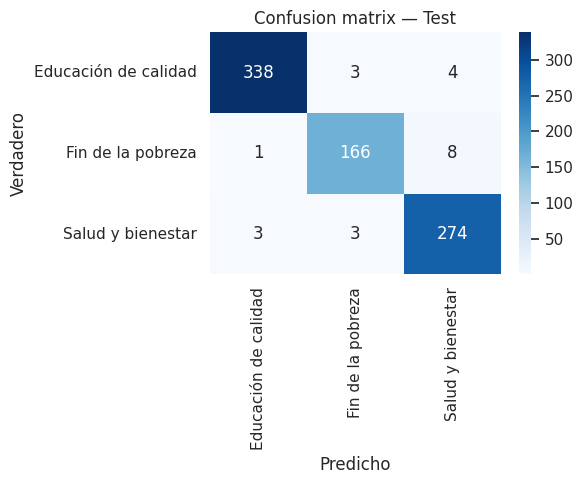

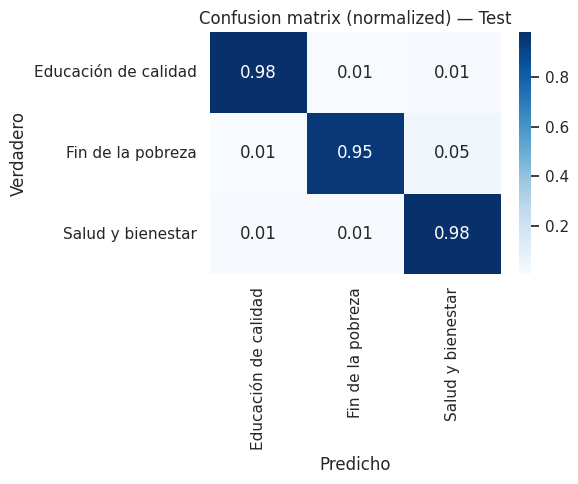

In [62]:

best = lr_tfidf.best_estimator_

ytr_pred = best.predict(train_corpus)
yte_pred = best.predict(test_corpus)

# =================================
# 4) Matrices de confusión (abs y norm)
# =================================
labels = np.unique(test_label_names)
cm = metrics.confusion_matrix(test_label_names, yte_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix — Test'); plt.xlabel('Predicho'); plt.ylabel('Verdadero')
plt.tight_layout(); plt.show()

cm_norm = metrics.confusion_matrix(test_label_names, yte_pred, labels=labels, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix (normalized) — Test')
plt.xlabel('Predicho'); plt.ylabel('Verdadero')
plt.tight_layout(); plt.show()








In [63]:


# Definir la función para calcular y devolver las métricas
def metricas(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

# Calcular las métricas para el conjunto de entrenamiento
mtr_train = metricas(train_label_names, ytr_pred)

# Calcular las métricas para el conjunto de prueba
mtr_test = metricas(test_label_names, yte_pred)

# ---

### Impresión de resultados


print("\n## Métricas en el conjunto de prueba (Test)")
for metric, value in mtr_test.items():
    print(f"- {metric.capitalize()}: {value:.4f}")

print("\n## Reporte de Clasificación (Test)")
print(classification_report(test_label_names, yte_pred, digits=4, zero_division=0))


## Métricas en el conjunto de prueba (Test)
- Accuracy: 0.9725
- Precision_weighted: 0.9726
- Recall_weighted: 0.9725
- F1_weighted: 0.9725
- F1_macro: 0.9697

## Reporte de Clasificación (Test)
                      precision    recall  f1-score   support

Educación de calidad     0.9883    0.9797    0.9840       345
   Fin de la pobreza     0.9651    0.9486    0.9568       175
   Salud y bienestar     0.9580    0.9786    0.9682       280

            accuracy                         0.9725       800
           macro avg     0.9705    0.9690    0.9697       800
        weighted avg     0.9726    0.9725    0.9725       800



La matriz de confusión y las metricas demuestra el desempeño del modelo de Regresión Logística sobre el conjunto de prueba, evaluando la clasificación en los tres ODS (Educación de calidad, Fin de la pobreza y Salud y bienestar). Estos resultados confirman la efectividad del modelo en cuanto a su capacidad de generalización.

## 5.3 Linear SVM: Matriz de Confusion y Análisis de Métricas

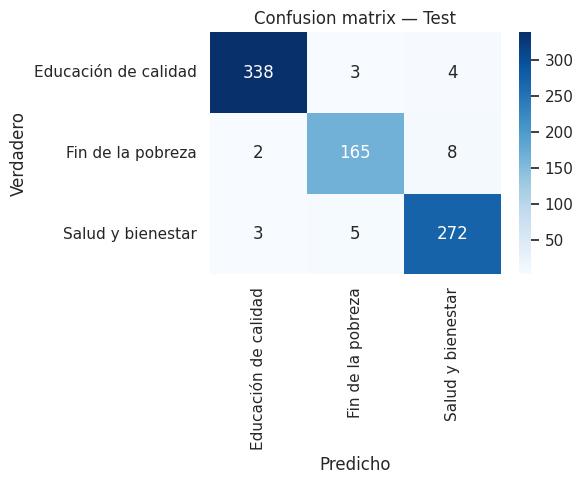

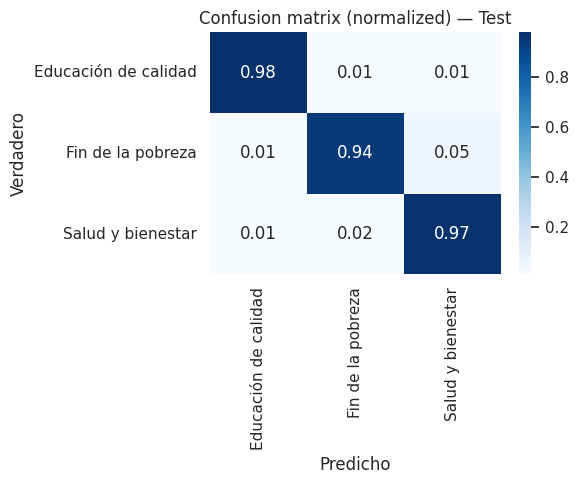

In [64]:

best = gs_svm.best_estimator_

ytr_pred = best.predict(train_corpus)
yte_pred = best.predict(test_corpus)

# =================================
# 4) Matrices de confusión (abs y norm)
# =================================
labels = np.unique(test_label_names)
cm = metrics.confusion_matrix(test_label_names, yte_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix — Test'); plt.xlabel('Predicho'); plt.ylabel('Verdadero')
plt.tight_layout(); plt.show()

cm_norm = metrics.confusion_matrix(test_label_names, yte_pred, labels=labels, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix (normalized) — Test')
plt.xlabel('Predicho'); plt.ylabel('Verdadero')
plt.tight_layout(); plt.show()







In [65]:


# Definir la función para calcular y devolver las métricas
def metricas(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

# Calcular las métricas para el conjunto de entrenamiento
mtr_train = metricas(train_label_names, ytr_pred)

# Calcular las métricas para el conjunto de prueba
mtr_test = metricas(test_label_names, yte_pred)

# ---

### Impresión de resultados


print("\n## Métricas en el conjunto de prueba (Test)")
for metric, value in mtr_test.items():
    print(f"- {metric.capitalize()}: {value:.4f}")

print("\n## Reporte de Clasificación (Test)")
print(classification_report(test_label_names, yte_pred, digits=4, zero_division=0))


## Métricas en el conjunto de prueba (Test)
- Accuracy: 0.9688
- Precision_weighted: 0.9688
- Recall_weighted: 0.9688
- F1_weighted: 0.9688
- F1_macro: 0.9651

## Reporte de Clasificación (Test)
                      precision    recall  f1-score   support

Educación de calidad     0.9854    0.9797    0.9826       345
   Fin de la pobreza     0.9538    0.9429    0.9483       175
   Salud y bienestar     0.9577    0.9714    0.9645       280

            accuracy                         0.9688       800
           macro avg     0.9656    0.9647    0.9651       800
        weighted avg     0.9688    0.9688    0.9688       800



5.3 XGBoost:  Análisis de Métricas

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# 1. Reporte de clasificación
print("Reporte de clasificación (test):\n")
print(classification_report(y_test_decoded, y_pred, digits=4))

# 2. f1 ponderado
f1_w = f1_score(y_test_decoded, y_pred, average="weighted")
print(f"\n✅ f1_weighted en test: {f1_w:.4f}")

# 3. Matriz de confusión
cm = confusion_matrix(y_test_decoded, y_pred, labels=le.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión (ODS)")
plt.show()

# 4. Gráfico de F1 por clase
report_dict = classification_report(y_test_decoded, y_pred, output_dict=True)
f1_scores = {cls: report_dict[str(cls)]['f1-score'] for cls in le.classes_}

plt.figure(figsize=(6,4))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")
plt.ylim(0,1)
plt.title("F1-score por clase (ODS)")
plt.xlabel("ODS")
plt.ylabel("F1-score")
plt.show()


Reporte de clasificación (test):



NameError: name 'y_test_decoded' is not defined

Al aplicar el modelo sobre un nuevo conjunto de prueba, los resultados variaron respecto a la evaluación inicial: mientras que en la validación previa el Linear SVM con TF-IDF alcanzaba el mejor desempeño (F1 ≈ 0.9797), en este nuevo escenario el Naive Bayes resultó ser el modelo con mayor rendimiento (F1 ≈ 0.9726). Esta diferencia puede deberse a la naturaleza de los datos de prueba, donde las distribuciones de términos o la presencia de clases menos representadas favorecen un enfoque probabilístico como Naive Bayes, más robusto en contextos de vocabulario reducido o variaciones léxicas. Aunque la caída en desempeño es ligera, este resultado resalta la importancia de evaluar los modelos en diferentes particiones y conjuntos externos, pues un modelo que parece superior en validación cruzada puede no mantener esa ventaja en datos nuevos. Así, se evidencia la necesidad de considerar tanto métricas cuantitativas como la estabilidad del modelo frente a datos cambiantes al momento de seleccionar la solución final.

# Predicciones

In [67]:
predicciones=pd.read_excel("/content/Datos de prueba_proyecto (1).xlsx")

In [68]:
predicciones.head()

,Textos_espanol
0,"El rector, que es el representante local del M..."
1,Tenga en cuenta que todos los programas antipo...
2,"Debido a que son en gran medida invisibles, es..."
3,Los recursos aún son limitados en este sector....
4,"Durante el período 1985-2008, la educación pri..."


In [69]:

X_new = predicciones["Textos_espanol"].astype(str).fillna("").tolist()

# 1) Etiquetas predichas
y_pred = gs_tf.predict(X_new)

           # nombres de clases en el orden de las columnas de probas

# 3) Armar resultados
predicciones = predicciones.copy()
predicciones["prediccion"] = y_pred




# 4) Ver/guardar
print(predicciones[["Textos_espanol", "prediccion"]])
predicciones.to_csv("predicciones_nb.csv", index=False)


                                        Textos_espanol            prediccion
0    El rector, que es el representante local del M...  Educación de calidad
1    Tenga en cuenta que todos los programas antipo...     Fin de la pobreza
2    Debido a que son en gran medida invisibles, es...     Fin de la pobreza
3    Los recursos aún son limitados en este sector....     Salud y bienestar
4    Durante el período 1985-2008, la educación pri...  Educación de calidad
..                                                 ...                   ...
147  En Croacia, Grecia y Rumanía, 1 de cada 3 niño...     Fin de la pobreza
148  El informe también es una adición oportuna a l...     Salud y bienestar
149  Además, de los 1200 millones que salieron de l...     Fin de la pobreza
150  Aunque el porcentaje de población en situación...     Fin de la pobreza
151  El CSG estaba inicialmente destinado a niños p...     Fin de la pobreza

[152 rows x 2 columns]


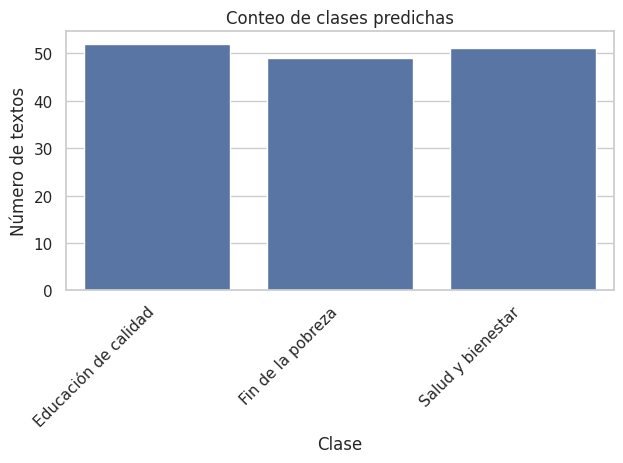

In [70]:

sns.set(style="whitegrid")
plt.figure()
ax = sns.countplot(data=predicciones, x="prediccion")
ax.set_title("Conteo de clases predichas")
ax.set_xlabel("Clase")
ax.set_ylabel("Número de textos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


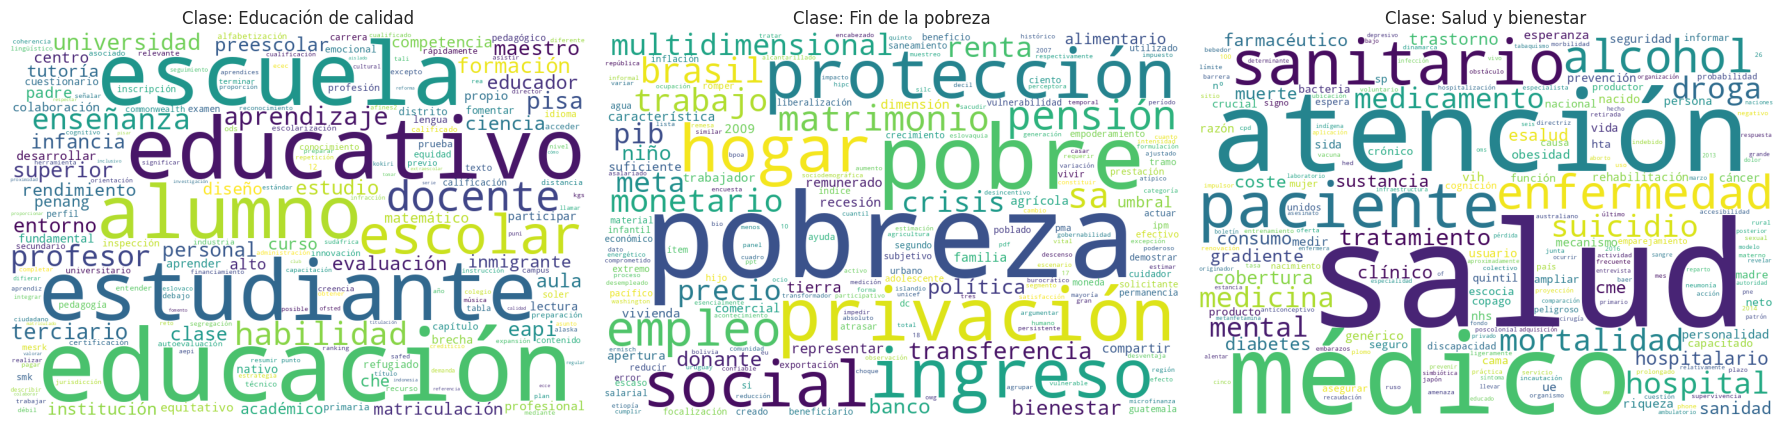

In [71]:
# pip install wordcloud  # si no lo tienes
import math
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) Extrae vocabulario y pesos del mejor SVM
tfidf   = gs_svm.best_estimator_.named_steps["tfidf"]
svm     = gs_svm.best_estimator_.named_steps["svm"]
terms   = np.array(tfidf.get_feature_names_out())
coefs   = svm.coef_              # shape: (n_clases, n_features)
classes = svm.classes_

def wc_for_class(i: int, topk: int = 200, positive_only: bool = True):
    w = coefs[i].copy()
    if positive_only:
        w[w < 0] = 0.0           # solo términos que favorecen a la clase i
    idx = np.argsort(w)[::-1][:topk]
    # usa '_' para mantener bigramas como una unidad visual
    freqs = {terms[j].replace(" ", "_"): float(w[j]) for j in idx if w[j] > 0}
    if not freqs:  # respaldo por si todos quedaron <=0
        idx = np.argsort(np.abs(coefs[i]))[::-1][:topk]
        freqs = {terms[j].replace(" ", "_"): float(abs(coefs[i, j])) for j in idx}
    wc = WordCloud(
        width=900, height=600, background_color="white",
        collocations=False, normalize_plurals=False, prefer_horizontal=1.0
    )
    return wc.generate_from_frequencies(freqs)

# 2) Mostrar nubes en grilla
n = len(classes)
cols = min(3, n); rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.5*rows))
axes = np.atleast_1d(axes).ravel()

for i, cls in enumerate(classes):
    img = wc_for_class(i, topk=200, positive_only=True)
    axes[i].imshow(img); axes[i].set_title(f"Clase: {cls}"); axes[i].axis("off")
for j in range(i+1, rows*cols):
    axes[j].axis("off")

plt.tight_layout(); plt.show()


In [72]:
# === 1) Extrae vectorizador y NB del mejor pipeline ===
best = gs_tf.best_estimator_                     # usa tu GridSearchCV ya entrenado
vec  = best.named_steps.get('tf') or best.named_steps.get('tfidf')
nb   = best.named_steps['mnb']

terms   = vec.get_feature_names_out()
classes = nb.classes_
logP    = nb.feature_log_prob_                   # [n_clases, n_terms]

def _top_terms_df(class_idx, k=10, relative=True, pos_only=True, wrap_width=16):
    """
    relative=True -> distintividad: logP - promedio(logP) entre clases.
    pos_only=True -> trunca negativos a 0 para evitar ruido visual.
    """
    w = logP[class_idx].copy()
    if relative and logP.shape[0] > 1:
        w = w - logP.mean(axis=0)
    if pos_only:
        w = np.where(w < 0, 0, w)
    idx = np.argsort(w)[::-1][:k]
    df = pd.DataFrame({"term": terms[idx], "score": w[idx]})
    df["term_wrapped"] = df["term"].apply(lambda s: "\n".join(wrap(s, wrap_width)))
    return df

def plot_top_terms_for_class(class_label, k=10, relative=True, pos_only=True,
                             wrap_width=16, height=4.5, aspect=1.6, save_path=None):
    """
    Genera UN gráfico para UNA clase. class_label puede ser índice (int) o nombre (str).
    """
    # Resuelve índice de clase
    if isinstance(class_label, int):
        ci = class_label
        cls_name = classes[ci]
    else:
        ci = int(np.where(classes == class_label)[0][0])
        cls_name = class_label

    df = _top_terms_df(ci, k=k, relative=relative, pos_only=pos_only, wrap_width=wrap_width)

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(aspect*height, height))
    sns.barplot(data=df, x="score", y="term_wrapped", ax=ax)

    xlabel = "Score (logP término|clase – promedio entre clases)" if relative else "logP(término|clase)"
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Término")
    ax.set_title(f"Top {k} términos - Clase: {cls_name}", pad=10)
    ax.tick_params(axis='y', labelrotation=0)

    # Anotar valores
    for p in ax.patches:
        val = p.get_width()
        ax.text(val, p.get_y() + p.get_height()/2, f"{val:.2f}", va='center', ha='left', fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()


In [73]:
import textwrap as tw
# === 1) Extrae vectorizador y NB del mejor pipeline ===
best = gs_tf.best_estimator_                     # usa tu GridSearchCV ya entrenado
vec  = best.named_steps.get('tf') or best.named_steps.get('tfidf')
nb   = best.named_steps['mnb']

terms   = vec.get_feature_names_out()
classes = nb.classes_
logP    = nb.feature_log_prob_                   # [n_clases, n_terms]

def _top_terms_df(class_idx, k=10, relative=True, pos_only=True, wrap_width=16):
    """
    relative=True -> distintividad: logP - promedio(logP) entre clases.
    pos_only=True -> trunca negativos a 0 para evitar ruido visual.
    """
    w = logP[class_idx].copy()
    if relative and logP.shape[0] > 1:
        w = w - logP.mean(axis=0)
    if pos_only:
        w = np.where(w < 0, 0, w)
    idx = np.argsort(w)[::-1][:k]
    df = pd.DataFrame({"term": terms[idx], "score": w[idx]})
    df["term_wrapped"] = df["term"].apply(lambda s: tw.fill(str(s), width=wrap_width))
    return df

def plot_top_terms_for_class(class_label, k=10, relative=True, pos_only=True,
                             wrap_width=16, height=4.5, aspect=1.6, save_path=None):
    """
    Genera UN gráfico para UNA clase. class_label puede ser índice (int) o nombre (str).
    """
    # Resuelve índice de clase
    if isinstance(class_label, int):
        ci = class_label
        cls_name = classes[ci]
    else:
        ci = int(np.where(classes == class_label)[0][0])
        cls_name = class_label

    df = _top_terms_df(ci, k=k, relative=relative, pos_only=pos_only, wrap_width=wrap_width)

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(aspect*height, height))
    sns.barplot(data=df, x="score", y="term_wrapped", ax=ax)

    xlabel = "Score (logP término|clase – promedio entre clases)" if relative else "logP(término|clase)"
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Término")
    ax.set_title(f"Top {k} términos - Clase: {cls_name}", pad=10)
    ax.tick_params(axis='y', labelrotation=0)

    # Anotar valores
    for p in ax.patches:
        val = p.get_width()
        ax.text(val, p.get_y() + p.get_height()/2, f"{val:.2f}", va='center', ha='left', fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

In [74]:
import pandas as pd

sample_texts = [
    # texto, etiqueta esperada
    ("La escuela rural necesita más docentes capacitados y materiales; las evaluaciones no reflejan el aprendizaje real.", "Educación de calidad"),
    ("Las becas de matrícula y tutorías personalizadas mejorarían el rendimiento de los estudiantes en zonas vulnerables.", "Educación de calidad"),
    ("La plataforma virtual falla y los docentes no reciben formación en el uso de herramientas digitales.", "Educación de calidad"),
    ("El sistema educativo requiere rúbricas claras y retroalimentación oportuna.", "Educación de calidad"),
    ("Sin conectividad y bibliotecas, el nivel de lectura de los escolares cae.", "Educación de calidad"),

    ("El ingreso del hogar no alcanza para la canasta básica; urge empleo formal y capacitación.", "Fin de la pobreza"),
    ("Transferencias condicionadas y cuidado infantil ayudarían a madres cabeza de hogar.", "Fin de la pobreza"),
    ("El microcrédito para emprendimientos barriales puede reducir la pobreza en zonas periféricas.", "Fin de la pobreza"),
    ("Las tarifas de servicios públicos asfixian a los más pobres; se necesita tarifa diferencial.", "Fin de la pobreza"),
    ("La pobreza infantil aumenta por informalidad laboral y falta de protección social.", "Fin de la pobreza"),

    ("La atención médica se demora meses y muchos pacientes pierden citas por falta de información.", "Salud y bienestar"),
    ("La salud mental requiere tamizaje y acompañamiento psicológico en escuelas y empresas.", "Salud y bienestar"),
    ("La telemedicina mejora el acceso en municipios rurales dispersos.", "Salud y bienestar"),
    ("Falta de medicamentos para hipertensión y diabetes en el hospital público.", "Salud y bienestar"),
    ("Urge mejorar la experiencia del paciente y reducir los tiempos de espera en urgencias.", "Salud y bienestar"),

    # Mixtos/ambiguos
    ("Sin empleo estable es imposible pagar la matrícula universitaria.", "Fin de la pobreza"),
    ("El estrés por deudas está afectando la salud mental de las familias.", "Salud y bienestar"),
    ("Docentes reportan burnout y necesitan apoyo psicológico.", "Educación de calidad"),
    ("El subsidio de transporte escolar reduce la deserción en colegios de bajos ingresos.", "Educación de calidad"),
    ("La clínica agenda por WhatsApp, pero muchos usuarios no tienen datos móviles.", "Salud y bienestar"),
]

df = pd.DataFrame(sample_texts, columns=["texto", "esperado"])

best = gs_tf.best_estimator_  # tu mejor pipeline TF-IDF + LinearSVC
df["prediccion"] = best.predict(df["texto"])
df["ok"] = df["prediccion"] == df["esperado"]
print(df[["texto","esperado","prediccion","ok"]].to_string(index=False))


                                                                                                              texto             esperado           prediccion    ok
 La escuela rural necesita más docentes capacitados y materiales; las evaluaciones no reflejan el aprendizaje real. Educación de calidad Educación de calidad  True
Las becas de matrícula y tutorías personalizadas mejorarían el rendimiento de los estudiantes en zonas vulnerables. Educación de calidad Educación de calidad  True
               La plataforma virtual falla y los docentes no reciben formación en el uso de herramientas digitales. Educación de calidad Educación de calidad  True
                                        El sistema educativo requiere rúbricas claras y retroalimentación oportuna. Educación de calidad Educación de calidad  True
                                          Sin conectividad y bibliotecas, el nivel de lectura de los escolares cae. Educación de calidad Educación de calidad  True
                

F1 global: 0.9497435897435897
                  clase  precision    recall  f1-score  support
0  Educación de calidad      1.000  0.857143  0.923077      7.0
1     Fin de la pobreza      1.000  1.000000  1.000000      6.0
2     Salud y bienestar      0.875  1.000000  0.933333      7.0


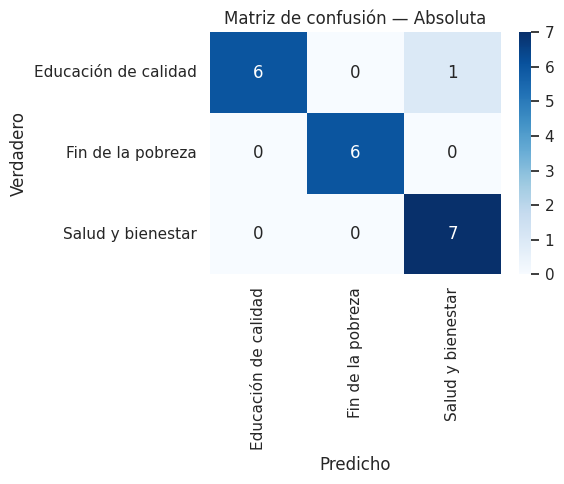

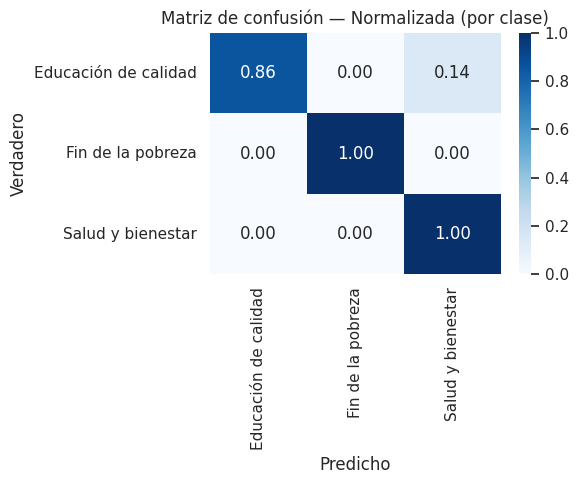

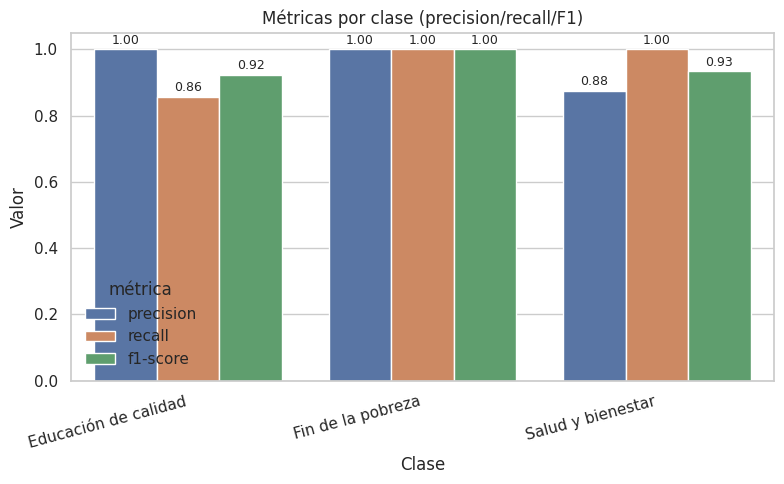

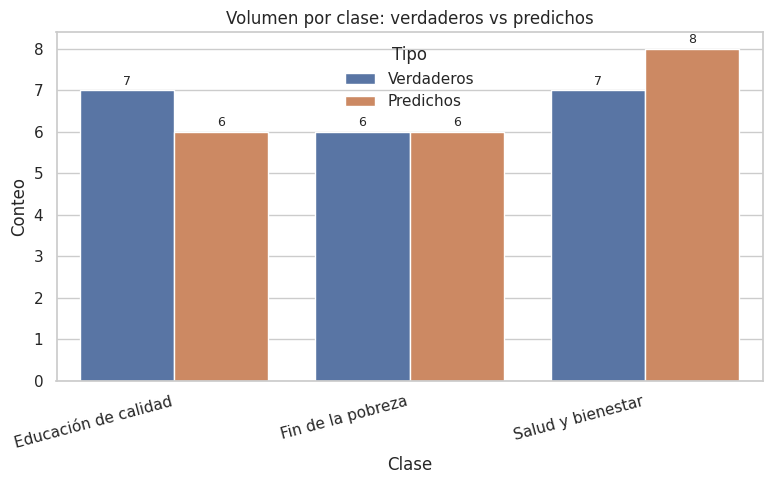

In [75]:


sns.set_theme(style="whitegrid")

# 0) Si aún no tienes predicciones en df, descomenta:
# best = gs_svm.best_estimator_
# df["prediccion"] = best.predict(df["texto"])

# 1) Asegura tipos consistentes
y_true = df["esperado"].astype(str).values
y_pred = df["prediccion"].astype(str).values
labels = np.unique(np.concatenate([y_true, y_pred]))

# 2) Métricas por clase con classification_report
rep = metrics.classification_report(y_true, y_pred, labels=labels,
                                    output_dict=True, zero_division=0)
rep_df = pd.DataFrame(rep).T
perclass = (rep_df.loc[labels, ["precision","recall","f1-score","support"]]
            .reset_index().rename(columns={"index":"clase"}))

print("F1 global:", metrics.f1_score(y_true, y_pred, average="weighted"))
print(perclass)

# 3) Matriz de confusión (absoluta)
cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de confusión — Absoluta")
plt.xlabel("Predicho"); plt.ylabel("Verdadero")
plt.tight_layout(); plt.show()

# 4) Matriz de confusión (normalizada por fila = recall por clase)
cm_norm = metrics.confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.title("Matriz de confusión — Normalizada (por clase)")
plt.xlabel("Predicho"); plt.ylabel("Verdadero")
plt.tight_layout(); plt.show()

# 5) Barras: precisión / recall / F1 por clase
metrics_long = perclass.melt(
    id_vars=["clase","support"],
    value_vars=["precision","recall","f1-score"],
    var_name="métrica", value_name="valor"
)
plt.figure(figsize=(8,5))
ax = sns.barplot(data=metrics_long, x="clase", y="valor", hue="métrica")
ax.set_ylim(0, 1.05)
for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", padding=2, fontsize=9)
plt.title("Métricas por clase (precision/recall/F1)")
plt.xlabel("Clase"); plt.ylabel("Valor")
plt.xticks(rotation=15, ha="right")
plt.tight_layout(); plt.show()

# 6) Conteos: verdaderos vs predichos por clase
counts_true = pd.Series(y_true).value_counts().reindex(labels, fill_value=0).rename("Verdaderos")
counts_pred = pd.Series(y_pred).value_counts().reindex(labels, fill_value=0).rename("Predichos")
counts_df = pd.concat([counts_true, counts_pred], axis=1).reset_index().rename(columns={"index":"clase"})
counts_long = counts_df.melt(id_vars="clase", var_name="Tipo", value_name="Conteo")

plt.figure(figsize=(8,5))
ax = sns.barplot(data=counts_long, x="clase", y="Conteo", hue="Tipo")
for c in ax.containers:
    ax.bar_label(c, padding=2, fontsize=9)
plt.title("Volumen por clase: verdaderos vs predichos")
plt.xlabel("Clase"); plt.ylabel("Conteo")
plt.xticks(rotation=15, ha="right")
plt.tight_layout(); plt.show()


# Conclusiones
En este proyecto se aplicaron diferentes algoritmos de clasificación de texto (Naive Bayes, Regresión Logística, SVM y XGBoost) para identificar opiniones ciudadanas relacionadas con los ODS 1 (Pobreza), 3 (Salud) y 4 (Educación).

El modelo de Naive Bayes se destacó como el de mejor desempeño global, logrando un f1-score ponderado cercano al 0.94, mostrando robustez especialmente en la categoría de Salud y bienestar, que resultaba la más desafiante.

Regresión Logística y SVM también mostraron buenos resultados, siendo más consistentes en las clases de Educación y Pobreza, lo que confirma que modelos lineales son competitivos con representaciones TF-IDF.

El modelo adicional con XGBoost alcanzó métricas sólidas (f1 ponderado ≈ 0.92), pero no superó a los modelos lineales ni a Naive Bayes en este caso, por lo que no se consideró como el modelo principal.

El proceso de preparación de datos (limpieza, normalización y vectorización con TF-IDF) fue clave para garantizar resultados de calidad, evidenciando que en problemas de texto el preprocesamiento es tan importante como la elección del algoritmo.

Como aprendizaje, se identificó la importancia de contar con más datos balanceados, ya que esto ayudaría a mejorar la generalización del modelo y a reducir riesgos de sobreajuste.

En conclusión, el modelo de Naive Bayes fue seleccionado como el más adecuado para ser integrado en la aplicación del proyecto, gracias a su equilibrio entre desempeño, simplicidad computacional y posibilidad de reentrenamiento continuo.